In [1]:
#!mkdir -p data/PittsburghBridge
#!wget -P data/PittsburghBridge https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz

In [1]:
from typing import Tuple, NamedTuple
from functools import partial
import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from rasterize_points import rasterize_points, _rasterize_points_iter, render_points, depth2disp, ndc_to_screen

In [2]:
from rasterize_points import floatbits2int, intbits2float, pack_fragments, unpack_fragments

https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html#jax.numpy.ndarray.at

# Load Pointcloud

In [3]:
data = np.load('data/PittsburghBridge/pointcloud.npz')
points, rgb = jnp.asarray(data['verts']), jnp.asarray(data['rgb'])
points.shape, rgb.shape

((438544, 3), (438544, 4))

# Simple Perspective Camera

In [4]:
def normalize(x, ord=None, axis=-1):
    return x / jnp.linalg.norm(x, ord, axis=axis, keepdims=True)

def look_at(at: jnp.ndarray, to: jnp.ndarray=(0, 0, 0), tmp: jnp.ndarray=(0, 1, 0), dtype=jnp.float32):
    at, to, tmp = map(partial(jnp.asarray, dtype=dtype), (at, to, tmp))
    forward = normalize(to - at)
    right = jnp.cross(normalize(tmp), forward)
    up = jnp.cross(forward, right)
    R = jnp.stack([right, up, forward], -1)
    return R, at

def perspective_map(points):
    assert points.shape[-1] == 3
    # (x,y,z) --> (x/z, y/z, z)
    x, y, z = jnp.rollaxis(points, -1)
    return jnp.stack([x/z, -y/z, z], -1)

In [5]:
image_size = (512, 512)
focal = 10

K = jnp.array([
    [focal, 0.0,  0.0],
    [0.0,  focal, 0.0],
    [0.0,  0.0,   1.0]], dtype=jnp.float32)

R = jnp.array([
    [-1.0,  0.0000, -0.0000],
    [ 0.0,  0.9848, -0.1736],
    [ 0.0, -0.1736, -0.9848]], dtype=jnp.float32)

t = jnp.array([0, 0, 10], dtype=jnp.float32)

In [6]:
R, t = look_at(jnp.array([0, 0, 12], dtype=jnp.float32), points.mean(0))
R, t

(DeviceArray([[-9.9883938e-01,  1.0575891e-04,  2.1979741e-03],
              [ 0.0000000e+00,  9.9768496e-01, -4.8116539e-02],
              [-2.1979741e-03, -4.8060693e-02, -9.9883938e-01]],            dtype=float32),
 DeviceArray([ 0.,  0., 12.], dtype=float32))

In [7]:
projected_points = perspective_map((points @ R.T + t) @ K.T)
projected_points.min(), projected_points.max()

(DeviceArray(-0.8189755, dtype=float32), DeviceArray(11.627578, dtype=float32))

In [8]:
raster = rasterize_points(projected_points, image_size)

In [9]:
depth = raster.zbuf
depth = depth - depth.min()
depth = depth / jnp.where(jnp.isfinite(depth), depth, -jnp.inf).max()

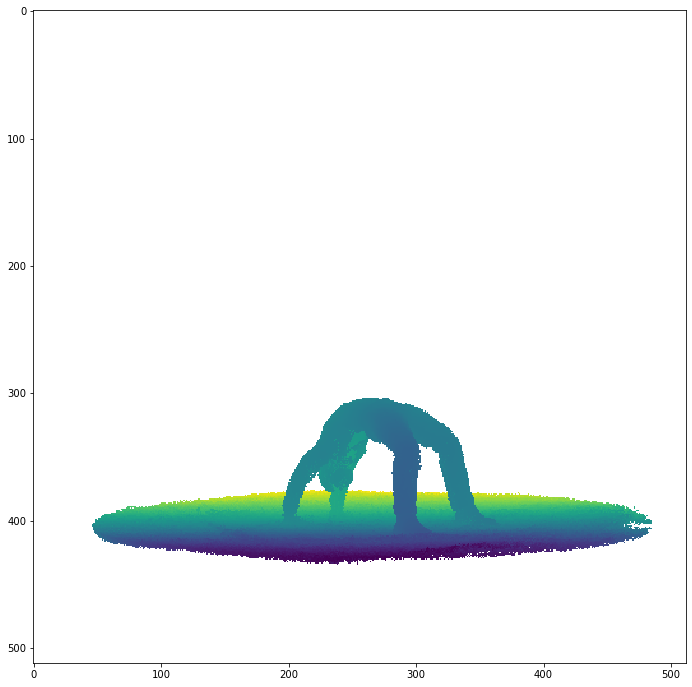

In [11]:
fig, ax = plt.subplots(1, figsize=(12,12))
ax.imshow(depth, interpolation='nearest')

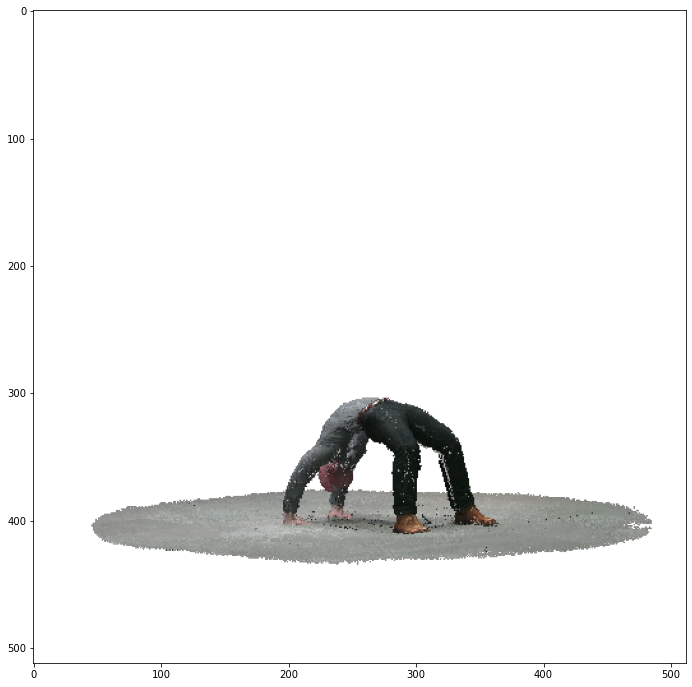

In [14]:
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(rgb.at[..., raster.idxs[..., 0], :].get(mode='fill', fill_value=0.0));

In [15]:
it = _rasterize_points_iter(projected_points, image_size)

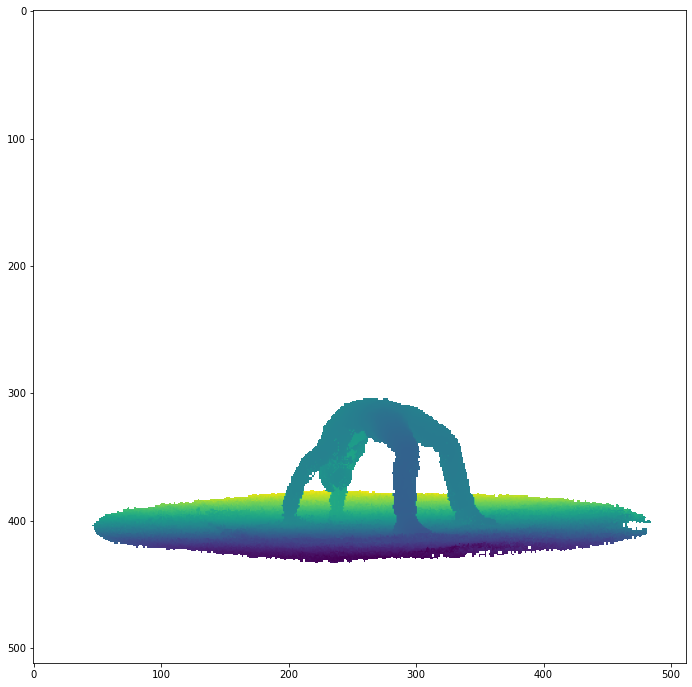

In [16]:
r1 = next(it)
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(r1.zbuf)

In [17]:
ndc_to_screen(np.linspace(-1, 1, 12)[:, None], 12)[:, 0] - .5

DeviceArray([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],            dtype=float64)

NameError: name '_di' is not defined

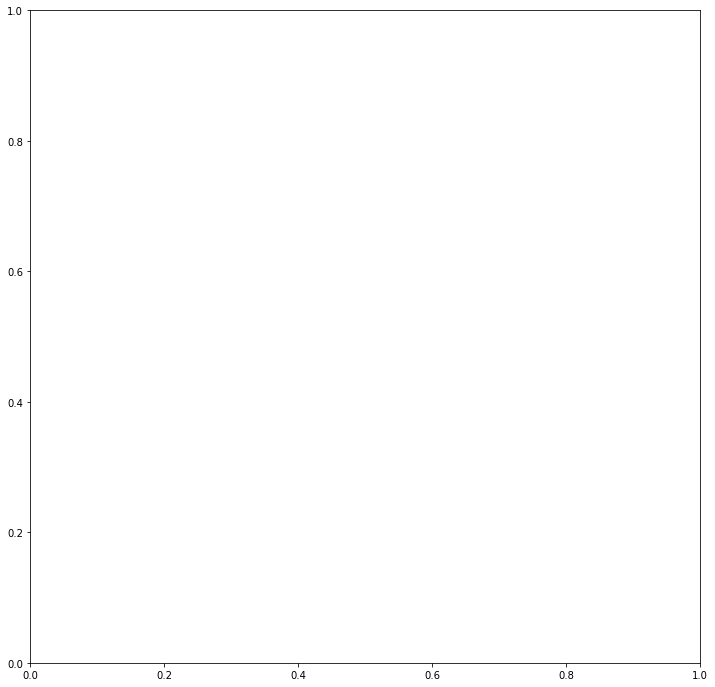

In [18]:
xy = projected_points[..., :2]
_alphas = xy
xy = ndc_to_screen(xy, image_size)
_alphas = (1 - jnp.sqrt(jnp.sum(((xy - .5).round(0) + .5 - xy)**2, -1)))[..., None]

alphas = jnp.where(r1.valid[..., None], _alphas[..., r1.idxs, :], 0)

fig, ax = plt.subplots(1, figsize=(12, 12))
#ax.imshow(alphas)

#image = alphas *  _di(rgb, jnp.s_[..., r1.idxs, :], 199)

ax.imshow(alphas * _di(rgb[:, :3], jnp.s_[..., r1.idxs, :], 0));

In [19]:
r2 = next(it)
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(r2.zbuf)

StopIteration: 

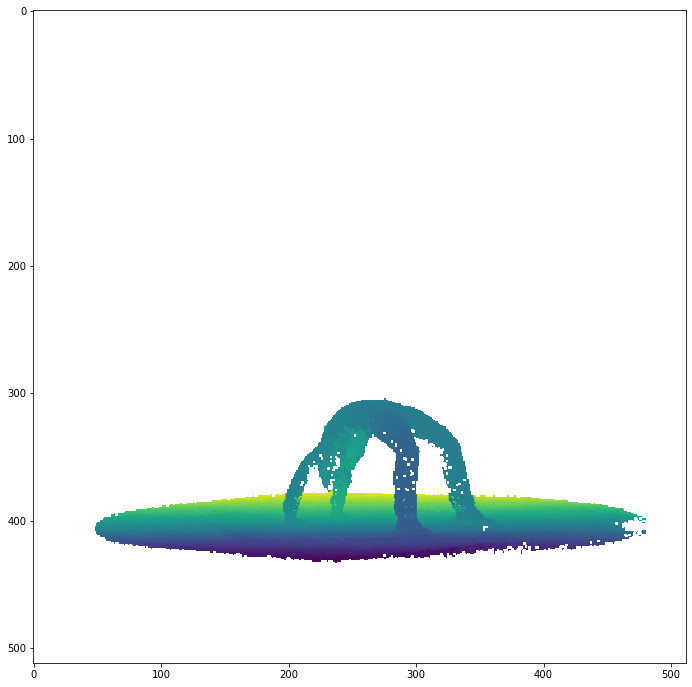

In [19]:
r3 = next(it)
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(r3.zbuf)

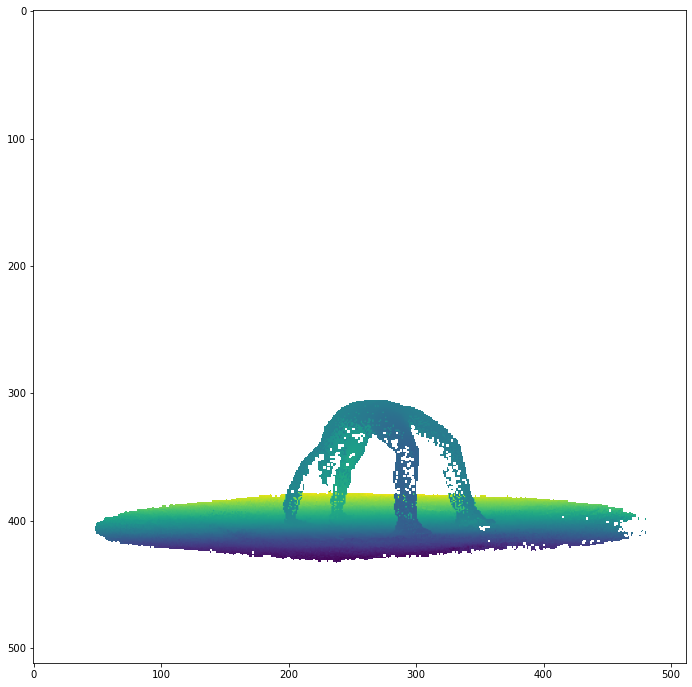

In [20]:
r4 = next(it)
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(r4.zbuf)

In [16]:
%timeit image = render_points(projected_points, rgb, background, (512, 512), k=8, blend=1, ndc=True)

36.9 ms ± 973 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
ndc

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
fill_value argument to indexed get()
While tracing the function render_points at /home/penn/remote_work/projects2/jax-rasterize/rasterize_points.py:147 for jit, this value became a tracer due to JAX operations on these lines:

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /home/penn/remote_work/projects2/jax-rasterize/rasterize_points.py:163 (render_points)

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

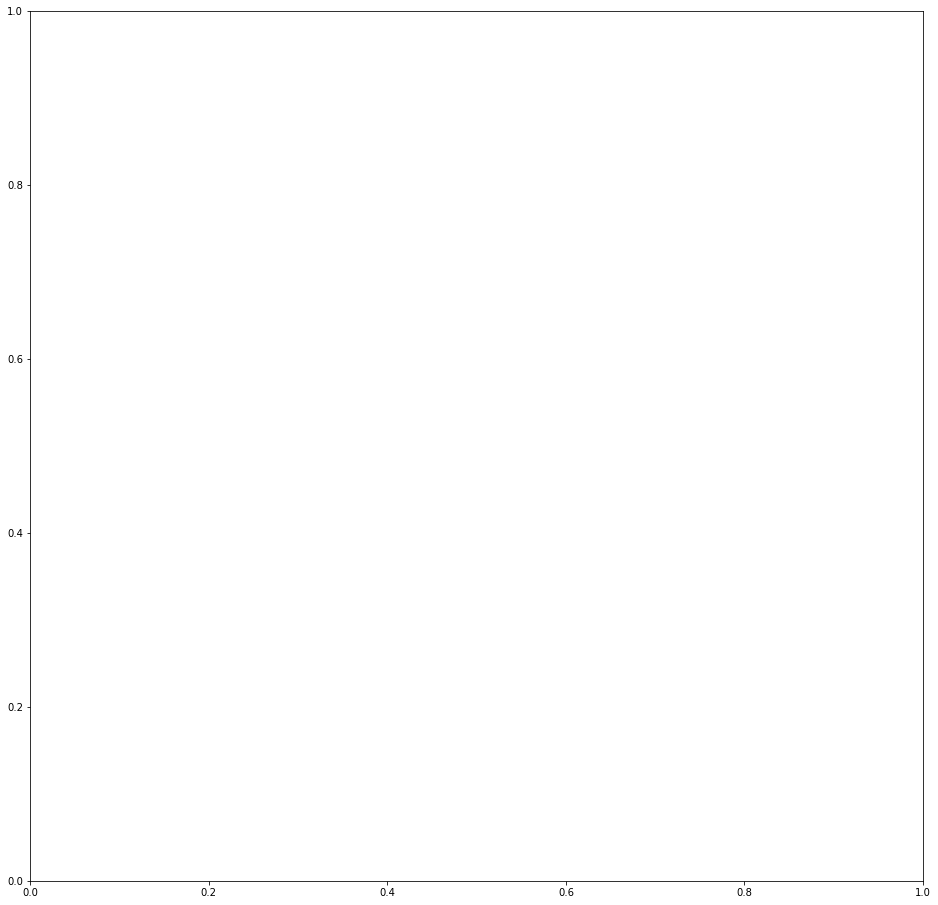

In [20]:
background = jnp.array([1, 0, 0, 1])
fig, ax = plt.subplots(1, figsize=(16, 16))
image, depth_image = render_points(projected_points, rgb, background, (512, 512), k=5, blend=1, ndc=True)
ax.imshow(image[:, :, :3], interpolation='nearest');

In [12]:
ax.imshow?

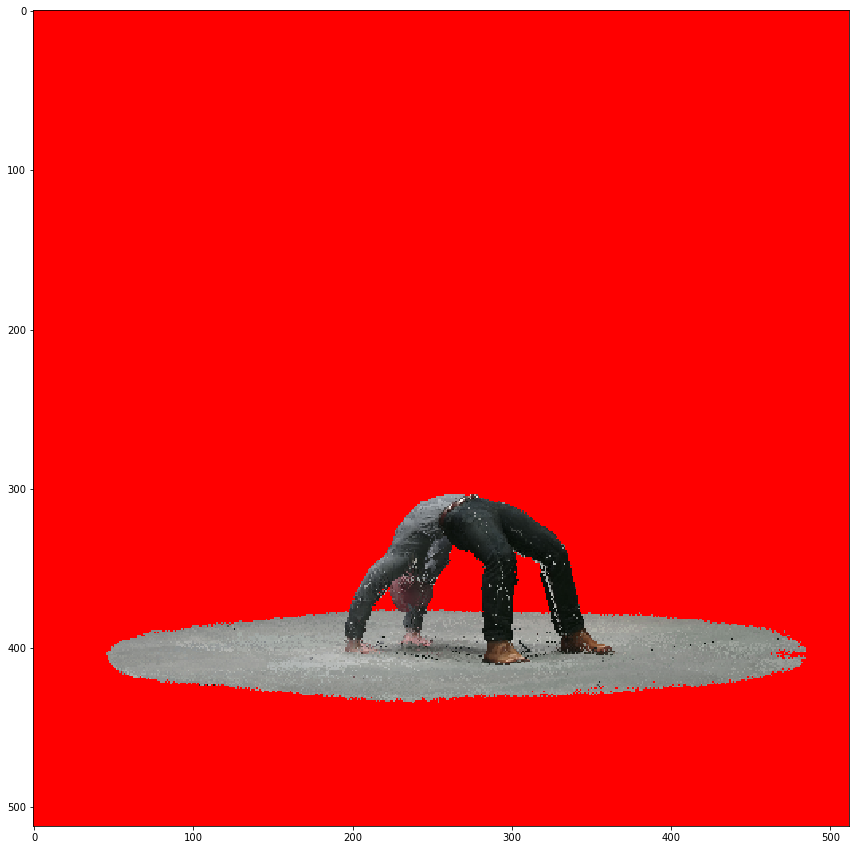

In [13]:
image = jnp.where(raster.valid[..., None], rgb[..., raster.idxs, :], background)

fig, ax = plt.subplots(1, figsize=(15, 15))
plt.imshow(image[:, :, :4], interpolation='nearest')